# Case Study 4 : Data Science in Email Data

**Required Readings:** 
* [Enron Emails](https://www.kaggle.com/wcukierski/enron-email-dataset) 
* Please download the Enron Email dataset from [here](https://www.cs.cmu.edu/~./enron/).
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Email Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

When a company goes through a large negative event, such as an investigation by the government, does a change in company morale occur?

Changes in company moral affect the wellbeing of a company, as moral lowers the work rate and quality tend to dicline and as such need to be adressed as soon as posible. 

# Data Collection/Processing: 

# Data Exploration: Exploring the Email Dataset

** plot email communication graph/network** 
* each node is an email account
* the weight of an edge between two accounts depends on how many emails have been sent between them.

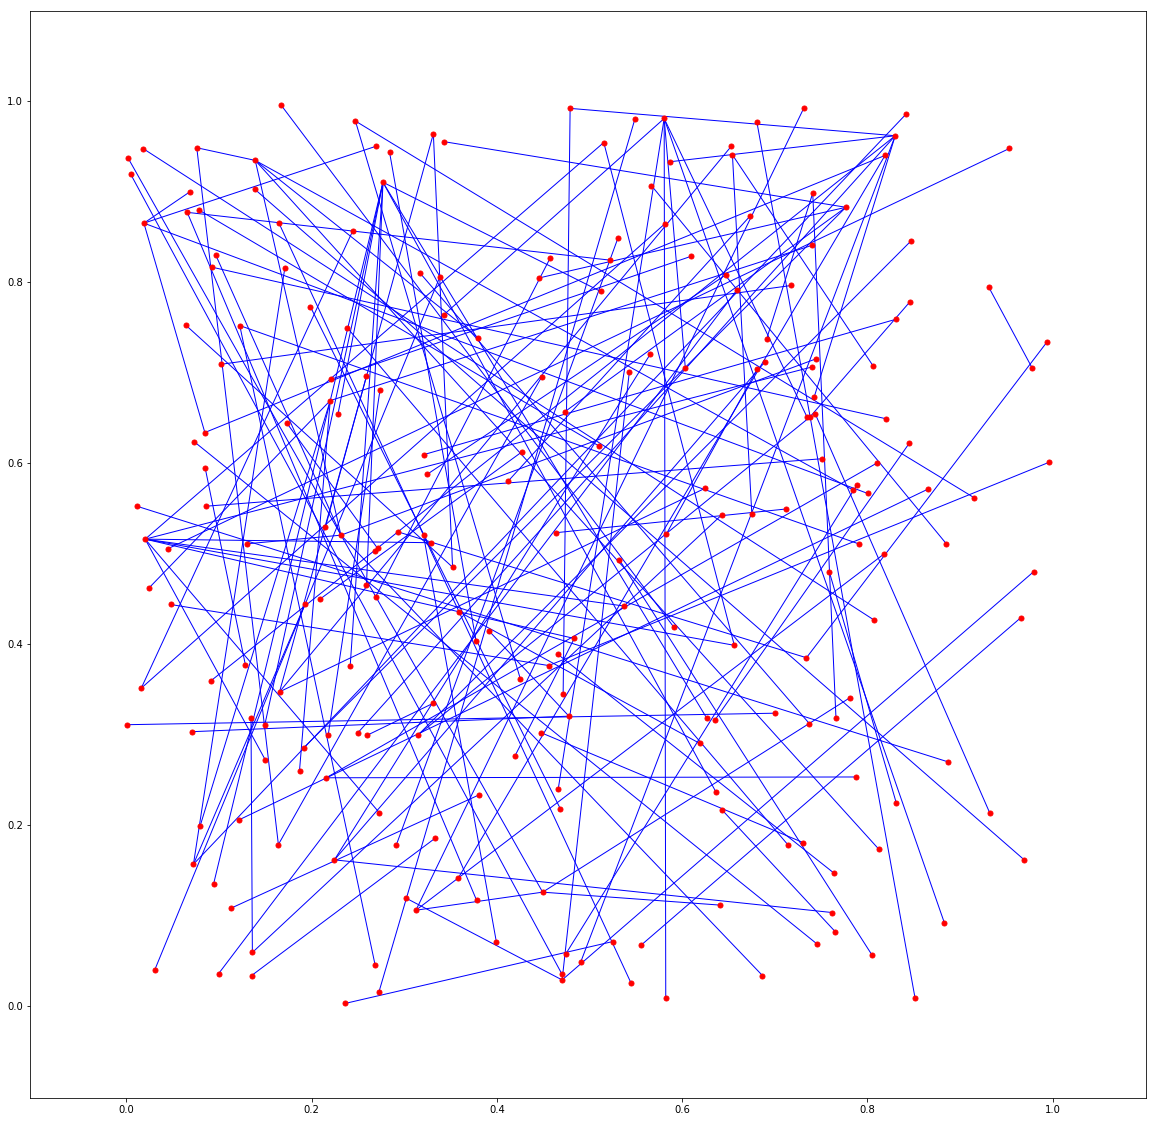

In [2]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import networkx as nx


pd.options.mode.chained_assignment = None
'''
chunk = pd.read_csv('emails.csv', chunksize=1000)
data = next(chunk)
'''
data = pd.read_csv('emails.csv').sample(200)




def get_text(Series, row_num_slicer):
   """returns a Series with text sliced from a list split from each message. Row_num_slicer
   tells function where to slice split text to find only the body of the message."""
   result = pd.Series(index=Series.index)
   for row, message in enumerate(Series):
       message_words = message.split('\n')
       del message_words[:row_num_slicer]
       result.iloc[row] = message_words
   return result

def get_row(Series, row_num):
   """returns a single row split out from each message. Row_num is the index of the specific
   row that you want the function to return."""
   result = pd.Series(index=Series.index)
   for row, message in enumerate(Series):
       message_words = message.split('\n')
       message_words = message_words[row_num]
       result.iloc[row] = message_words
   return result
def get_address(df, Series, num_cols=1):
   """returns a specified email address from each row in a Series"""
   address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
   addresses = []
   result1 = pd.Series(index=df.index)
   result2 = pd.Series(index=df.index)
   result3 = pd.Series(index=df.index)
   for i in range(len(df)):
       for message in Series:
           correspondents = re.findall(address, message)
           addresses.append(correspondents)
           result1[i] = addresses[i][0]
       if num_cols >= 2:
           if len(addresses[i]) >= 3:
               result2[i] = addresses[i][1]
               if num_cols == 3:
                   if len(addresses[i]) >= 4:
                       result3[i] = addresses[i][2]
   return result1, result2, result3
def standard_format(df, Series, string, slicer):
   """Drops rows containing messages without some specified value in the expected locations.
   Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
   rows = []
   for row, message in enumerate(Series):
       message_words = message.split('\n')
       if string not in message_words[slicer]:
           rows.append(row)
   df = df.drop(df.index[rows])
   return df


x = len(data.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
   data = standard_format(data, data.message, v, i)
data = data.reset_index()

data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['senders'] = get_row(data.message, 2)
data['recipients'] = get_row(data.message, 3)
data['subject'] = get_row(data.message, 4)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

data.subject = data.subject.str.replace('Subject: ', '')

data['recipient1'], data['recipient2'], data['recipient3'] = get_address(data, data.recipients, num_cols=3)
data['sender'], x, y = get_address(data, data.senders)

del data['recipients']
del data['senders']
del data['file']
del data['message']

data = data[['date', 'sender', 'recipient1', 'recipient2', 'recipient3', 'subject', 'text']]
G = nx.from_pandas_dataframe(data, 'sender', 'recipient1', edge_attr=['date', 'subject'])

plt.figure(figsize=(20,20))
pos = nx.random_layout(G)

'''
spring_layout

'''
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We mainly focused on emails that were sent during the month of October, 2001, when the Enron scandal was publicized. 

We analyzed the number of emails sent as well as the sentiment in those emails to see how Enron employees were reacting to the scandal.

We also took an unsupervised approach to classify the October emails based on their message contents, which also could give us insights into employees' hehavior. 

Write codes to implement the solution in python:

In [3]:

import pandas as pd
import email
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from textblob import TextBlob
from datetime import datetime
import calendar

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [ ]:
## Extract emails SENT during Oct, 2001 and save to 'sent_oct.csv'

# # load raw data and extract email information
# raw = pd.read_csv('emails.csv', quoting=2)
# text = list(map(email.message_from_string, raw.message))

# email_keys = text[0].keys() # include ['Date', 'From', 'To', 'X-From', 'X-To', etc]

# # load some email information into the dataframe
# useful_keys = ['Date', 'From', 'To', 'X-From', 'X-To', 'X-Folder']
# for k in useful_keys:
#     raw[k] = [t[k] for t in text]

# # add email body into the dataframe
# raw['Body'] = [t.get_payload().lower() for t in text]

# # covert date to datetime
# raw['Date'] = pd.to_datetime(raw['Date'], infer_datetime_format=True)

# # look for only emails sent during Oct, 2001
# sent = raw[raw['file'].str.contains('sent')].drop(['message'], axis=1)
# sent_2001 = sent[sent.Date.dt.year == 2001]
# sent_oct = sent_2001[sent_2001.Date.dt.month == 10]
# #len(sent_oct) #8k
# #sent_oct.to_csv('sent_oct.csv')


In [4]:
## Convert raw email bodies to a matrix of TF-IDF features

stopwordsnew = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient', 'sent', 'attached'])
# load emails from Oct, 2001 in Sent folders
sent_oct = pd.read_csv('sent_oct.csv', index_col=0).reset_index()
#len(sent_oct) #8k

# clean out non-word from each body
sent_oct.Body = sent_oct.Body.apply(lambda x: ' '.join([i for i in x.split() if i.isalpha()]))

vect = TfidfVectorizer(stop_words=stopwordsnew, max_df=0.5, min_df=2)
X = vect.fit_transform(sent_oct.Body)

features = vect.get_feature_names()


In [5]:
## Clustering with KMeans
# N=3
clf = KMeans(n_clusters=3, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)

print centroid_coords

[[-0.01033164 -0.03579979]
 [ 0.3133661   0.17511424]
 [-0.02487373 -0.01186872]]


In [6]:
## helper functions

def get_daily_polarity(daily_list):
    score = 0
    for e in daily_list:
        alpha_only = [w for w in e.split() if w.isalpha()]
        blob = TextBlob(' '.join(alpha_only))
        score += blob.sentiment.polarity
    daily_mean = score/len(daily_list)
    return daily_mean

def top_feats(row, features, top_n=20):
    top_id = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in top_id]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label+1), fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#73C6B6')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [ ]:
#load and process the dataset into a dictionary

# load raw data and extract email information
raw = pd.read_csv('emails.csv', quoting=2)
text = [map(email.message_from_string, raw.message)]

email_keys = text[0][0].keys() # include ['Date', 'From', 'To', 'X-From', 'X-To', etc]

# load some email information into the dataframe
useful_keys = ['Date', 'From', 'To', 'X-From', 'X-To', 'X-Folder']
for k in useful_keys:
    raw[k] = [t[k] for t in text[0]]

# load email body into the dataframe
raw['Body'] = [t.get_payload().lower() for t in text[0]]

#process the data into a dictionary

TimeFrame = {}


emailText,index = np.unique(raw.Body.as_matrix(), return_index = True)



x = 0

while x < len(emailText):
    try:
        date = datetime.strptime(raw['Date'][index[x]][:-12], '%a, %d %b %Y %H:%M:%S')
    except:
        date = datetime.strptime(raw['Date'][index[x]][:-13], '%a, %d %b %Y %H:%M:%S')
    if str(date.year) not in TimeFrame:
        TimeFrame[str(date.year)] = {}
    if calendar.month_name[date.month] not in TimeFrame[str(date.year)]:
        TimeFrame[str(date.year)][calendar.month_name[date.month]] = {}
    if str(date.day) not in TimeFrame[str(date.year)][calendar.month_name[date.month]]:
        TimeFrame[str(date.year)][calendar.month_name[date.month]][str(date.day)] = []
    blob = TextBlob(emailText[x])
    values = []
    for scentence in blob.sentences:
        values.append(scentence.sentiment.polarity)
    data = [date, index[x], values]
    TimeFrame[str(date.year)][calendar.month_name[date.month]][str(date.day)].append(data)
    x = x + 1

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


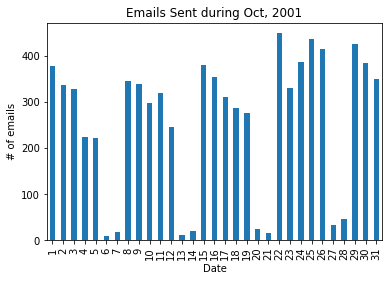

In [104]:
## Daily number of emails sent during Oct, 2001

#len(sent_oct) #8k
sent_oct['Date'] = pd.to_datetime(sent_oct['Date'], infer_datetime_format=True)
sent_oct_daily = sent_oct.groupby([sent_oct.Date.dt.day])['Body'].count()
sent_oct_daily.plot(kind='bar')

plt.title('Emails Sent during Oct, 2001')
plt.ylabel('# of emails')

plt.show()

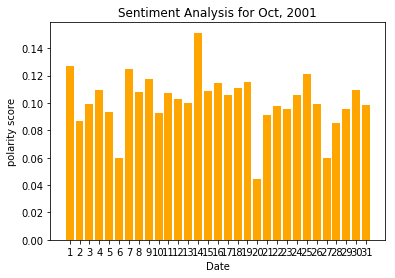

In [108]:
## Sentiment analysis on emails sent during Oct, 2001

date = np.arange(1,32)

# Create an email list for each day
list_sent_oct = []
for d in date:
    daily = sent_oct[sent_oct.Date.dt.day == d].Body.unique().tolist()
    list_sent_oct.append(daily)
len(list_sent_oct)

# Compute the polarity score for each day
score_oct_sent = []
for d in list_sent_oct:
    score_oct_sent.append(get_daily_polarity(d))
    
plt.bar(date, score_oct_sent, tick_label=date, color='orange')

plt.title('Sentiment Analysis for Oct, 2001')
plt.xlabel('Date')
plt.ylabel('polarity score')

plt.show()

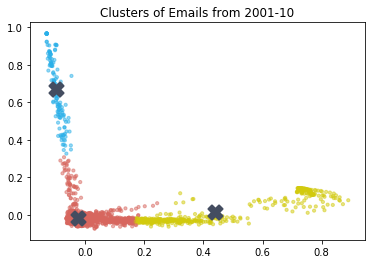

In [118]:
## Visualizing clusters on scatterplots

label_colors = ["#2AB0E9", "#D7665E", "#D2CA0D"]
colors = [label_colors[i] for i in labels]

plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.5, s=10)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')

plt.title('Clusters of Emails from 2001-10')

plt.show()

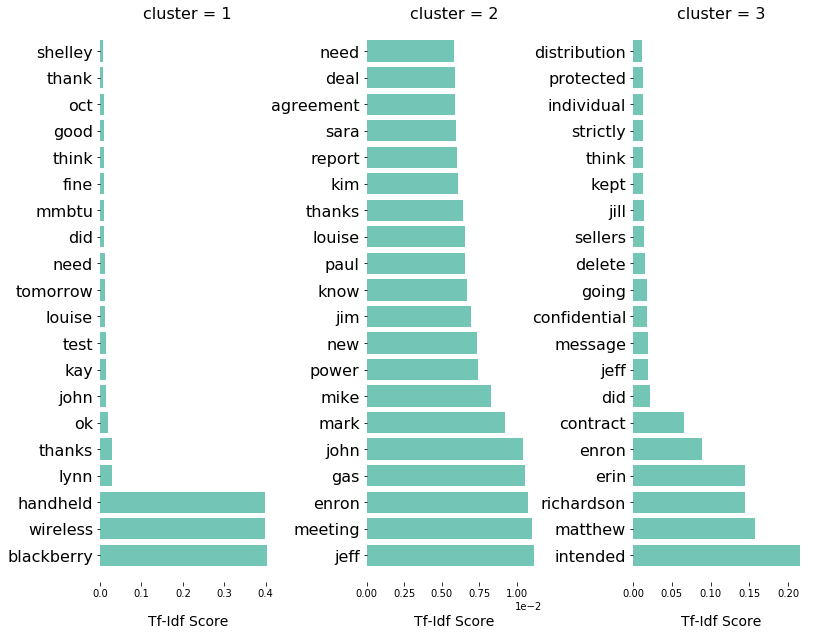

In [65]:
## Visualizating the most important words in each email cluster

plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 20))

Some words in the 3rd cluster look juicy, such as 'delete', 'confidential', 'contract', and 'seller'. This cluster could be used as a starting point for further in-depth analysis.

['1986', '1', '2044', '1997', '1979', '1999', '1998', '2002', '2000', '2001', '2020', '2007', '2004', '2005', '2', '2024', '2012', '2043']
Mon, 13 Feb 0002 09:29:38 -0800 (PST)
the following expense report is ready for approval:

employee name: grace l. blair
status last changed by: ava l. garcia
expense report name: madison, wi
report total: $1,056.35
amount due employee: $1,056.35


to approve this expense report, click on the following link for concur expense.
http://expensexms.enron.com
total monthly sentiment for 2001


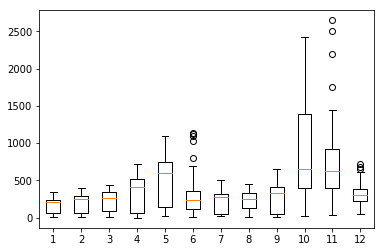

Average monthly sentiment for 2001


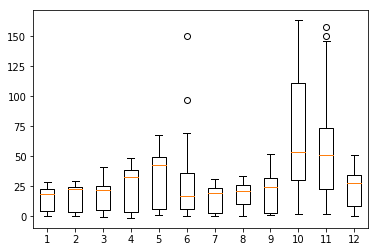

Total Daily sentiment for October 2001


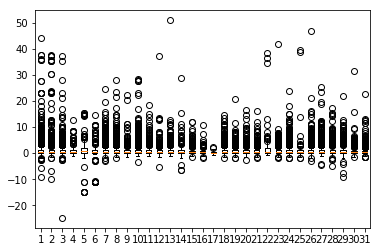

Average Daily sentiment for October 2001


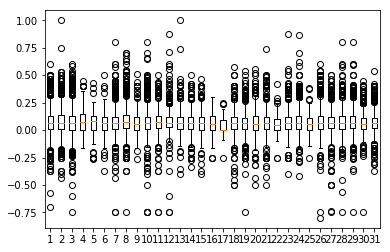

In [8]:
print(TimeFrame.keys())
#looking at one of the wierd dates, seems to be an automated system message
print(raw['Date'][52538])
print(raw['Body'][52538])


year = '2001'

months = calendar.month_name[1:13]

yearArraySum = []

for month in months:
    monthArray = []
    for day in TimeFrame[year][month].keys():
        daileyMailSentiment = 0
        
        for email in TimeFrame[year][month][day]:
            daileyMailSentiment = daileyMailSentiment + sum(email[2])
        monthArray.append(daileyMailSentiment)
    yearArraySum.append(monthArray)

print("total monthly sentiment for 2001")
plt.boxplot(yearArraySum)

plt.show()


yearArrayAverage = []

for month in months:
    monthArray = []
    for day in TimeFrame[year][month].keys():
        daileyMailSentiment = 0
        
        for email in TimeFrame[year][month][day]:
            daileyMailSentiment = daileyMailSentiment + sum(email[2])/len(email[2])
        monthArray.append(daileyMailSentiment)
    yearArrayAverage.append(monthArray)

print("Average monthly sentiment for 2001")
plt.boxplot(yearArrayAverage)

plt.show()



month = 'October'

OctoberArraySum = []

for day in TimeFrame[year][month].keys():
    daileyMailSentiment = []
        
    for email in TimeFrame[year][month][day]:
        daileyMailSentiment.append(sum(email[2]))
    OctoberArraySum.append(daileyMailSentiment)

print("Total Daily sentiment for October 2001")
plt.boxplot(OctoberArraySum)

plt.show()

OctoberArrayAverage = []

for day in TimeFrame[year][month].keys():
    daileyMailSentiment = []
        
    for email in TimeFrame[year][month][day]:
        daileyMailSentiment.append(sum(email[2])/len(email[2]))
    OctoberArrayAverage.append(daileyMailSentiment)

print("Average Daily sentiment for October 2001")
plt.boxplot(OctoberArrayAverage)

plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 5".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot email communication graph/network (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


